In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import string
from unidecode import unidecode
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time
import json

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, 
    GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, 
    Dropout, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import backend as K
import sklearn.metrics as skmetrics
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras import metrics as km
from keras.metrics import F1Score

import pickle
import sklearn.metrics as skmetrics

2025-08-07 17:12:05.969919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 17:12:05.970728: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 17:12:05.973957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 17:12:05.982731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754586725.997564   46443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754586726.00

# 1. EDA

Explorative analysis to understand the dataset.


First 5 rows of the dataset:


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0



Dataset information:
Number of rows: 159571
Number of columns: 8

Columns in the dataset:
['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']

Data types:


comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
sum_injurious     int64
dtype: object


Missing values per column:


comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


Distribution of toxicity categories:
toxic: 15294 comments (9.58%)
severe_toxic: 1595 comments (1.00%)
obscene: 8449 comments (5.29%)
threat: 478 comments (0.30%)
insult: 7877 comments (4.94%)
identity_hate: 1405 comments (0.88%)

Distribution of number of labels per comment:


num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

Percentage of non-toxic comments: 89.83%

Statistics on comment length:


count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

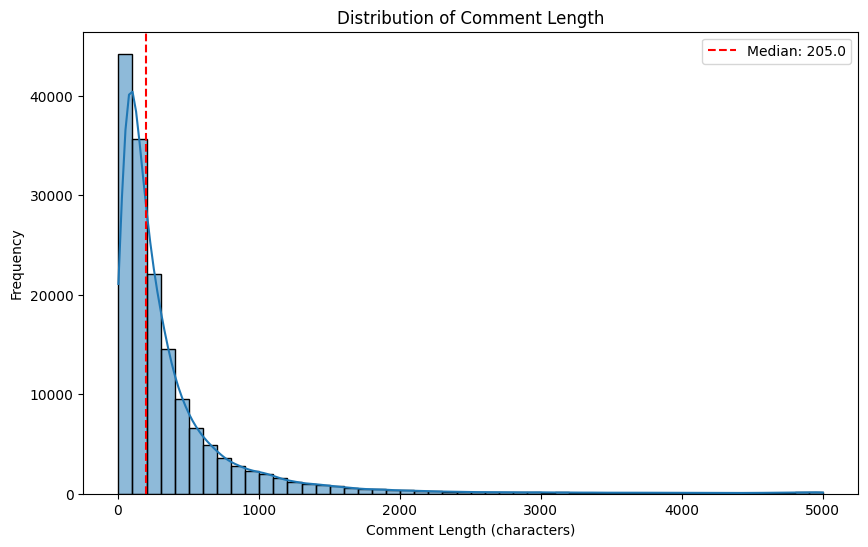


Examples of comments for each category:

--- Example of 'toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'severe_toxic' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'obscene' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'threat' comment ---
Hi! I am back again!
Last warning!
Stop undoing my edits or die!

--- Example of 'insult' comment ---
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

--- Example of 'identity_hate' comment ---
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gyp...


In [2]:
df = pd.read_csv('Filter_Toxic_Comments_dataset.csv')

print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\nData types:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isnull().sum())

toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Class distribution (how many comments per category)
print("\nDistribution of toxicity categories:")
for label in toxic_labels:
    count = df[label].sum()
    percentage = (count / len(df)) * 100
    print(f"{label}: {count} comments ({percentage:.2f}%)")

# Count of comments with multiple labels
df['num_labels'] = df[toxic_labels].sum(axis=1)
print("\nDistribution of number of labels per comment:")
display(df['num_labels'].value_counts().sort_index())
print(f"Percentage of non-toxic comments: {(df['num_labels'] == 0).mean() * 100:.2f}%")

# Comment length
df['comment_length'] = df['comment_text'].apply(len)
print("\nStatistics on comment length:")
display(df['comment_length'].describe())

# Visualization of comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['comment_length'].median(), color='r', linestyle='--', label=f'Median: {df["comment_length"].median()}')
plt.legend()
plt.show()

# Examples of comments for each category
print("\nExamples of comments for each category:")
for label in toxic_labels:
    print(f"\n--- Example of '{label}' comment ---")
    example = df[df[label] == 1]['comment_text'].iloc[0]
    print(example[:200] + "..." if len(example) > 200 else example)


Analyzing comments with multiple toxicity labels:

Most common label combinations:


/tmp/ipykernel_46443/3695296090.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)


toxic                                              5666
toxic-obscene-insult                               3800
toxic-obscene                                      1758
toxic-insult                                       1215
toxic-severe_toxic-obscene-insult                   989
toxic-obscene-insult-identity_hate                  618
obscene                                             317
insult                                              301
toxic-severe_toxic-obscene-insult-identity_hate     265
obscene-insult                                      181
Name: count, dtype: int64

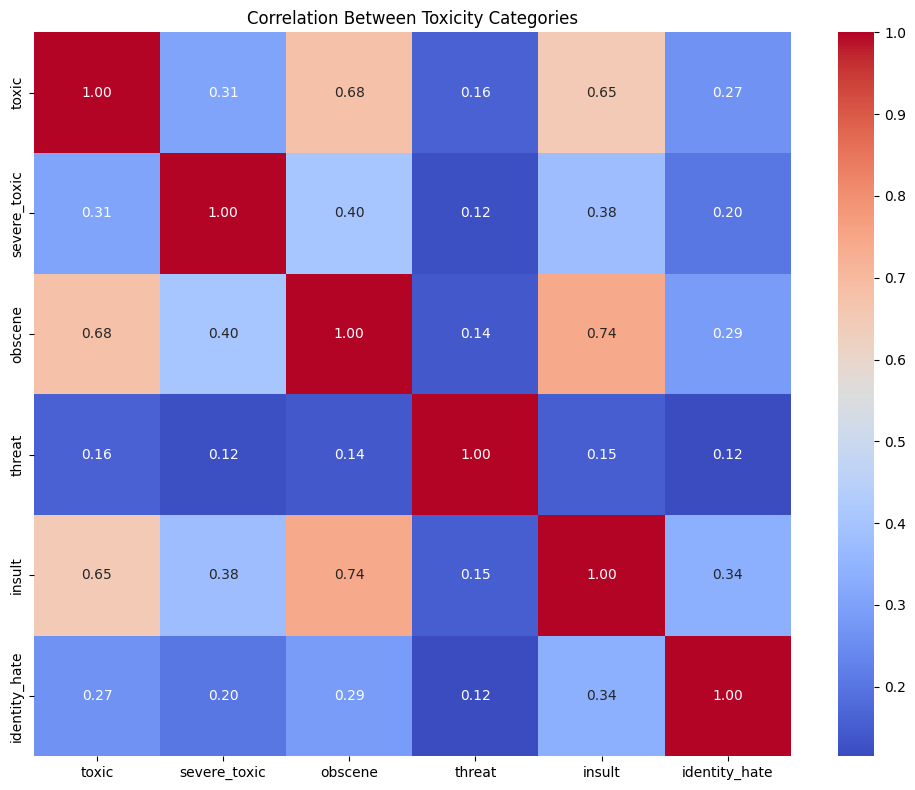

In [3]:
# Analyze comments with multiple labels
print("\nAnalyzing comments with multiple toxicity labels:")

# Count occurrences of label combinations
print("\nMost common label combinations:")
label_combos = df[toxic_labels].apply(lambda x: '-'.join(toxic_labels[i] for i in range(len(toxic_labels)) if x[i] == 1), axis=1)
top_combos = label_combos[label_combos != ''].value_counts().head(10)
display(top_combos)

plt.figure(figsize=(10, 8))
corr_matrix = df[toxic_labels].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Toxicity Categories")
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

#### Normalization

In [4]:
def normalize_text(text):
    """
    Normalize text with various techniques:
    - Convert to lowercase
    - Replace URLs with <URL> placeholder
    - Replace user mentions with <USER> placeholder
    - Handle emojis (convert to text)
    - Fix character repetitions ("sccccemo" → "scemo")
    - Convert leet speak ("1d10t" → "idiot")
    - Normalize unicode characters to ASCII
    - Standardize spacing
    """
    # Check if text is a string (some entries might be NaN)
    if not isinstance(text, str):
        return ""
    
    
    text = text.lower()

    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '<URL>', text)
    
    mention_pattern = r'@\w+'
    text = re.sub(mention_pattern, '<USER>', text)
    
    text = emoji.demojize(text)
    
    # Fix character repetitions (more than 2 of the same character)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
	# Identify and preserve dates and times before leet speak conversion
    # First, temporarily mark date/time patterns
    date_patterns = [
        # Time patterns (HH:MM)
        r'\b\d{1,2}:\d{2}\b',
        # Date patterns (MM/DD/YYYY, DD/MM/YYYY, YYYY/MM/DD)
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b',
        r'\b\d{2,4}-\d{1,2}-\d{1,2}\b',
        # Month name patterns
        r'\b\d{1,2}\s+(?:january|february|march|april|may|june|july|august|september|october|november|december)\b',
        r'\b(?:january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2}\b',
    ]
    
    # Temporary placeholders for dates/times
    date_replacements = {}
    for i, pattern in enumerate(date_patterns):
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for j, match in enumerate(matches):
            placeholder = f"<DATE_TIME_{i}_{j}>"
            date_replacements[placeholder] = match.group()
            text = text.replace(match.group(), placeholder)
            
    # Convert common leet speak patterns
    leet_patterns = {
        '0': 'o', '1': 'i', '3': 'e', '4': 'a', '5': 's', 
        '6': 'g', '7': 't', '8': 'b', '@': 'a', '$': 's'
    }
    for digit, letter in leet_patterns.items():
        text = text.replace(digit, letter)
    
    # Normalize unicode characters (optional - can be commented out if needed)
    text = unidecode(text)
    
    # Replace numbers with <NUM> placeholder
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    
    # Standardize spacing (remove extra spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Normalizing text data...


100%|██████████| 159571/159571 [01:09<00:00, 2308.79it/s]



Examples of original vs. normalized text:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
Normalized: explanation why the edits made under my username hardcore metallica fan were reverted? they weren't ...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11...
Normalized: d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) <DATE_TIME_o_o>, <...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant ...
Normalized: hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant ...

Original: "
More
I can't make any real suggestions on improvement - I wondered if the section statistics shoul...
Normalized: " more i can't make any real suggestions on improvement - i wondered if the section statistics shoul...

Original: You, sir, are my hero.

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


Statistics on text length after normalization:


count    159571.000000
mean        388.335800
std         582.028464
min           5.000000
25%          94.000000
50%         202.000000
75%         430.000000
max        5708.000000
Name: normalized_length, dtype: float64

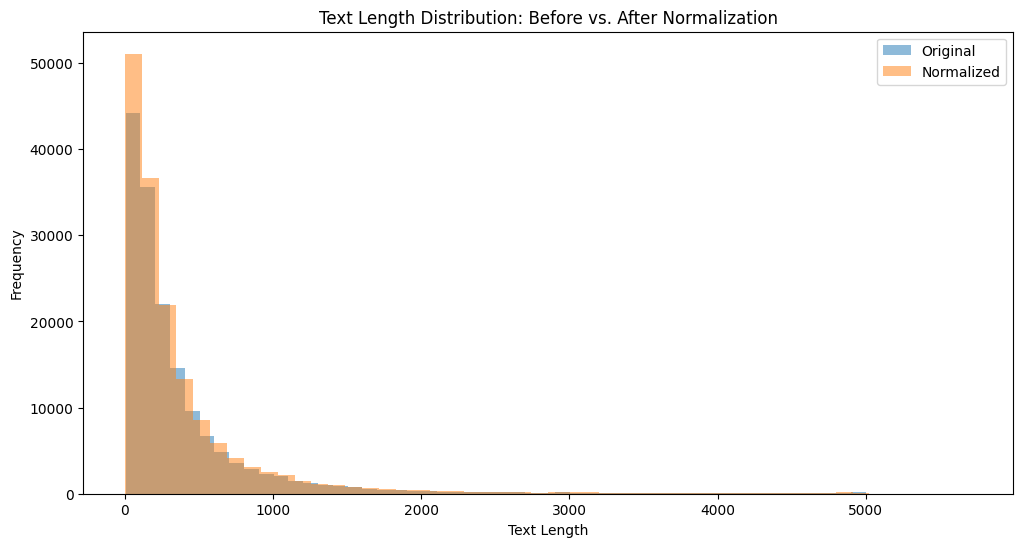

In [5]:
# Apply normalization to the dataset with progress bar
print("Normalizing text data...")
df['normalized_text'] = [normalize_text(text) for text in tqdm(df['comment_text'])]

# Display examples of original vs. normalized text
print("\nExamples of original vs. normalized text:")
for i in range(5):
    print(f"\nOriginal: {df['comment_text'].iloc[i][:100]}...")
    print(f"Normalized: {df['normalized_text'].iloc[i][:100]}...")

# Check if there are any remaining empty texts after normalization
empty_texts = df['normalized_text'].apply(lambda x: len(x) == 0).sum()
print(f"\nNumber of empty texts after normalization: {empty_texts}")

# Show statistics on text length before and after normalization
df['normalized_length'] = df['normalized_text'].apply(len)
print("\nStatistics on text length before normalization:")
display(df['comment_length'].describe())
print("\nStatistics on text length after normalization:")
display(df['normalized_length'].describe())

# Visualize the difference in text length
plt.figure(figsize=(12, 6))
plt.hist(df['comment_length'], bins=50, alpha=0.5, label='Original')
plt.hist(df['normalized_length'], bins=50, alpha=0.5, label='Normalized')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution: Before vs. After Normalization')
plt.legend()
plt.show()

##### Tokenization

In [6]:
def calculate_oov_rate(texts, vectorizer):
    """Calculate the percentage of words not in vocabulary."""
    oov_count = 0
    total_count = 0
    
    for text in texts:
        words = text.split()
        total_count += len(words)
        
        for word in words:
            if word not in vectorizer.get_vocabulary():
                oov_count += 1
    
    return oov_count / total_count if total_count > 0 else 0

In [13]:
def process_in_batches(texts, vectorizer, batch_size=2048, max_sequence_length=1000):
    """Process texts in batches to improve performance."""
    num_samples = len(texts)
    sequences = np.zeros((num_samples, max_sequence_length), dtype=np.int32)

    for i in tqdm(range(0, num_samples, batch_size), desc="Processing batches"):
        end_idx = min(i + batch_size, num_samples)
        batch_texts = texts.iloc[i:end_idx].values
        sequences[i:end_idx] = vectorizer(batch_texts).numpy()
    
    return sequences

In [15]:
print("# 3. Tokenization")
start_time = time.time()

print(f"\nUtilize the full dataset ({len(df)} rows)...")
working_df = df

# Taking a sample for vocabulary creation
print("\nPreparing data for tokenization...")
sample_size_for_vocab = min(50000, len(working_df))
vocab_sample = working_df['normalized_text'].sample(sample_size_for_vocab, random_state=42).values

label_count = df[toxic_labels].sum(axis=1).clip(0, 6)
X_train, X_temp, y_train, y_temp = train_test_split(
        df['normalized_text'],
        df[toxic_labels],
        test_size=0.2,
        random_state=42,
        stratify=label_count)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=label_count[X_temp.index]
)

# Tokenizer parameters
max_tokens = 20000  
max_sequence_length = 128  


print("\nInitialization and adaptation of the tokenizer...")
word_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length,
    standardize=None 
)

print("Adapting the vocabulary...")
word_vectorizer.adapt(vocab_sample)
vocab_time = time.time()
print(f"Time to adapt the vocabulary: {vocab_time - start_time:.2f} seconds")

# Vocabulary information
word_vocab = word_vectorizer.get_vocabulary()
word_vocab_size = len(word_vocab)
print(f"Vocabulary size: {word_vocab_size} tokens")

# Tokenization examples
print("\nTokenization examples:")
for i in range(3):
    original_text = X_train.iloc[i][:50] + "..." if len(X_train.iloc[i]) > 50 else X_train.iloc[i]
    tokenized_text = word_vectorizer([X_train.iloc[i]]).numpy()[0]
    non_zero_tokens = tokenized_text[tokenized_text > 0]
    tokens = [word_vocab[idx] for idx in non_zero_tokens]
    print(f"\nOriginal: {original_text}")
    print(f"Token: {tokens[:10]}{'...' if len(tokens) > 10 else ''}")


print("\nConverting texts to sequences (batch processing)...")
print("Processing training set...")
X_train_sequences = process_in_batches(X_train, word_vectorizer, max_sequence_length=max_sequence_length)
print("Processing validation set...")
X_val_sequences = process_in_batches(X_val, word_vectorizer, max_sequence_length=max_sequence_length)
print("Processing test set...")
X_test_sequences = process_in_batches(X_test, word_vectorizer, max_sequence_length=max_sequence_length)

process_time = time.time()
print(f"Time to process all sequences: {process_time - vocab_time:.2f} seconds")

print(f"Training data shape: {X_train_sequences.shape}")
print(f"Validation data shape: {X_val_sequences.shape}")


# Calculate OOV rate on a small sample (use a smaller sample for speed)
print("\nCalculating OOV rate...")
sample_size = min(500, len(X_val))
oov_rate = calculate_oov_rate(X_val.sample(sample_size).values, word_vectorizer)
print(f"OOV rate in validation data: {oov_rate:.2%}")

# Saving tokenized data
print("\nSaving tokenized data...")
np.save('X_train_tokenized.npy', X_train_sequences)
np.save('X_val_tokenized.npy', X_val_sequences)
np.save('X_test_tokenized.npy', X_test_sequences)
np.save('y_train.npy', y_train.values)
np.save('y_val.npy', y_val.values)
np.save('y_test.npy', y_test.values)

with open('vocabulary.txt', 'w') as f:
    for word in word_vocab:
        f.write(f"{word}\n")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTokenization complete! Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# 3. Tokenization

Utilize the full dataset (159571 rows)...

Preparing data for tokenization...

Initialization and adaptation of the tokenizer...
Adapting the vocabulary...
Time to adapt the vocabulary: 0.86 seconds
Vocabulary size: 20000 tokens

Tokenization examples:

Original: comment signed by jackthomas
Token: [np.str_('comment'), np.str_('signed'), np.str_('by'), '[UNK]']

Original: the article is written in neutral language. it was...
Token: [np.str_('the'), np.str_('article'), np.str_('is'), np.str_('written'), np.str_('in'), np.str_('neutral'), np.str_('language.'), np.str_('it'), np.str_('was'), np.str_('sourced')]...

Original: " have sheperd instead. "
Token: [np.str_('"'), np.str_('have'), '[UNK]', np.str_('instead.'), np.str_('"')]

Converting texts to sequences (batch processing)...
Processing training set...


Processing batches: 100%|██████████| 63/63 [00:01<00:00, 45.79it/s]


Processing validation set...


Processing batches: 100%|██████████| 8/8 [00:00<00:00, 47.18it/s]


Processing test set...


Processing batches: 100%|██████████| 8/8 [00:00<00:00, 47.82it/s]


Time to process all sequences: 1.76 seconds
Training data shape: (127656, 128)
Validation data shape: (15957, 128)

Calculating OOV rate...
OOV rate in validation data: 8.17%

Saving tokenized data...

Tokenization complete! Total time: 907.03 seconds (15.12 minutes)


In [13]:
# 4. Class Imbalance Handling with Class Weights
print("# 4. Class Imbalance Handling with Class Weights")

# Load the training data
y_train = np.load('y_train.npy')

print("\nLabel distribution in training set:")
for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    pos_ratio = pos_count / y_train.shape[0]
    print(f"{label}: {pos_count} positive ({pos_ratio:.2%}), {neg_count} negative")

# Calculate weights for each class
print("\nCalculating class weights...")
class_weights = {}
weight_sums = []

for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    
    # Weight calculation: negatives / positives
    # To avoid division by zero
    if pos_count > 0:
        weight_pos = neg_count / pos_count
    else:
        weight_pos = 1.0
    
    weight_neg = 1.0  # Weight for negative class is always 1
    
    # Dictionary of weights for this class
    class_weights[i] = {0: weight_neg, 1: weight_pos}
    
    # For normalization
    avg_weight = (neg_count * weight_neg + pos_count * weight_pos) / y_train.shape[0]
    weight_sums.append(avg_weight)

# Normalize weights to have mean = 1
avg_weight_total = np.mean(weight_sums)
print(f"Average weight before normalization: {avg_weight_total:.4f}")

normalized_class_weights = {}
for i in class_weights:
    normalized_class_weights[i] = {
        0: class_weights[i][0] / avg_weight_total,
        1: class_weights[i][1] / avg_weight_total
    }

# Verify normalization
normalized_weight_sums = []
for i, label in enumerate(toxic_labels):
    pos_count = np.sum(y_train[:, i])
    neg_count = y_train.shape[0] - pos_count
    
    avg_norm_weight = (neg_count * normalized_class_weights[i][0] + 
                       pos_count * normalized_class_weights[i][1]) / y_train.shape[0]
    normalized_weight_sums.append(avg_norm_weight)

print(f"Average weight after normalization: {np.mean(normalized_weight_sums):.4f}")

# Display calculated weights
print("\nNormalized class weights:")
for i, label in enumerate(toxic_labels):
    print(f"{label}: Negative={normalized_class_weights[i][0]:.4f}, Positive={normalized_class_weights[i][1]:.4f}")

# Save class weights for training
import json
with open('class_weights.json', 'w') as f:
    # Convert keys to strings for JSON serialization
    serializable_weights = {str(k): {str(sk): sv for sk, sv in v.items()} 
                          for k, v in normalized_class_weights.items()}
    json.dump(serializable_weights, f)

print("\nClass weights saved to 'class_weights.json'")

# 4. Class Imbalance Handling with Class Weights

Label distribution in training set:
toxic: 12224 positive (9.58%), 115432 negative
severe_toxic: 1265 positive (0.99%), 126391 negative
obscene: 6761 positive (5.30%), 120895 negative
threat: 374 positive (0.29%), 127282 negative
insult: 6323 positive (4.95%), 121333 negative
identity_hate: 1132 positive (0.89%), 126524 negative

Calculating class weights...
Average weight before normalization: 1.9267
Average weight after normalization: 1.0000

Normalized class weights:
toxic: Negative=0.5190, Positive=4.9012
severe_toxic: Negative=0.5190, Positive=51.8580
obscene: Negative=0.5190, Positive=9.2808
threat: Negative=0.5190, Positive=176.6386
insult: Negative=0.5190, Positive=9.9597
identity_hate: Negative=0.5190, Positive=58.0119

Class weights saved to 'class_weights.json'


In [17]:

y_train = np.load('y_train.npy')
pos = y_train.sum(axis=0)                
neg = y_train.shape[0] - pos             


w_pos = neg / np.maximum(pos, 1)
w_pos = w_pos / w_pos.mean()
weights_dict = {label: float(weight) for label, weight in zip(toxic_labels, w_pos.round(2))}
print(weights_dict)

class_weights = tf.constant(w_pos, dtype=tf.float32)


def weighted_bce(y_true, y_pred):
    
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    # if y=1 apply w_pos, if y=0 leave 1
    weights = 1. + (class_weights - 1.) * y_true
    return tf.reduce_mean(bce * weights, axis=-1)


{'toxic': 0.09, 'severe_toxic': 1.0, 'obscene': 0.18, 'threat': 3.41, 'insult': 0.19, 'identity_hate': 1.12}


In [ ]:
# Model architecture
def build_model(sequence_length=128, vocab_size=20001, embedding_dim=200, n_classes=6, lr =2e-3):
    # 1. Input layer
    input_layer = Input(shape=(sequence_length,))
    
    # 2. Embedding layer with mask_zero=True
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        mask_zero=True
    )(input_layer)

    # 3. SpatialDropout1D to reduce overfitting in the embedding
    x = SpatialDropout1D(0.2)(x)

    # 4. BiLSTM layers (2 layers)
    x = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1))(x)

    # 5. Pooling: Concatenate Global Max and Global Average pooling
    max_pool = GlobalMaxPooling1D()(x)
    avg_pool = GlobalAveragePooling1D()(x)
    pooled = Concatenate()([max_pool, avg_pool])

    # 6. Final layers
    x = Dropout(0.4)(pooled)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(n_classes, activation='sigmoid')(x)
    
	# Optimizer
    optimizer = AdamW(
    learning_rate=lr,
    weight_decay=1e-4 
    )
    
    
    metric_list = [
    km.BinaryAccuracy(name="bin_acc", threshold=0.5),
    km.AUC(name="pr_auc", curve="PR",
           multi_label=True, num_labels=n_classes),
    km.F1Score(name="f1_macro", average="macro", threshold=0.5),
	]
    
    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=optimizer,
        loss=weighted_bce,
        metrics=metric_list
    )
        
    return model


In [18]:
# Load tokenized data from saved files
print("Loading tokenized data from saved files...")
X_train = np.load('X_train_tokenized.npy')
X_val = np.load('X_val_tokenized.npy')
X_test = np.load('X_test_tokenized.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Get the sequence length from the loaded data
max_sequence_length = X_train.shape[1]
print(f"Detected sequence length: {max_sequence_length}")

print(f"Loaded data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

# Load vocabulary from saved file
with open('vocabulary.txt', 'r') as f:
    saved_vocabulary = [line.strip() for line in f.readlines()]

# Get vocabulary size
vocab_size = len(saved_vocabulary)
print(f"Loaded vocabulary size: {vocab_size}")

# Get class weights from saved file and convert to the format needed for training
with open('class_weights.json', 'r') as f:
    serialized_weights = json.load(f)
    


Loading tokenized data from saved files...
Detected sequence length: 128
Loaded data shapes:
X_train: (127656, 128)
X_val: (15957, 128)
X_test: (15958, 128)
y_train: (127656, 6)
y_val: (15957, 6)
y_test: (15958, 6)
Loaded vocabulary size: 20000


In [ ]:
print("# 6. Model Training")

# Params
batch_size = 256  
max_epochs = 12
lr = 2e-3

model = build_model(
	sequence_length=max_sequence_length,
    vocab_size=vocab_size,
    embedding_dim=200,
    n_classes=len(toxic_labels),
    lr=2e-3  
)

print("\nModel summary:")
print(model.summary())

# Update callbacks with patience 4 for early stopping
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=4,  
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=0.00001
    )
]


print(f"\nStarting training with batch size={batch_size}, max_epochs={max_epochs}")
print(f"Using AdamW optimizer with learning rate {lr}")
print(f"Training on {len(X_train)} examples, validating on {len(X_val)} examples")

start_time = time.time()

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Save the trained model and history
model.save('final_model.keras')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("\nModel and training history saved successfully.")


# 6. Model Training

Starting training with batch size=1024, max_epochs=6
Using AdamW optimizer with learning rate 2e-3
Training on 127656 examples, validating on 15957 examples
Epoch 1/6


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - bin_acc: 0.1420 - f1_macro: 0.0699 - loss: 14300.7939 - pr_auc: 0.0396
Epoch 1: val_loss improved from None to 4.79798, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - bin_acc: 0.1012 - f1_macro: 0.0696 - loss: 10307.8232 - pr_auc: 0.0417 - val_bin_acc: 0.0537 - val_f1_macro: 0.0690 - val_loss: 4.7980 - val_pr_auc: 0.0404 - learning_rate: 0.0020
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - bin_acc: 0.0934 - f1_macro: 0.0702 - loss: 5868.4468 - pr_auc: 0.0366
Epoch 2: val_loss improved from 4.79798 to 3.73726, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 557s 4s/step - bin_acc: 0.0749 - f1_macro: 0.0691 - loss: 5316.0820 - pr_auc: 0.0340 - val_bin_acc: 0.1137 - val_f1_macro: 0.0690 - val_loss: 3.7373 - val_pr_auc: 0.0399 - learning_rate: 0.0020
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - bin_acc: 0.0579 - f1_macro: 0.0682 - loss: 4871.2104 - pr_auc: 0.0340
Epoch 3: val_loss did not imp

: 

2025-08-07 15:56:01.874508: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 15:56:01.907626: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 15:56:02.145987: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 15:56:02.297974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754582162.580189   34472 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754582162.63

# 7. Model Evaluation
Loading test data...
Loading the best model...


2025-08-07 15:56:06.150704: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Plotting training history...


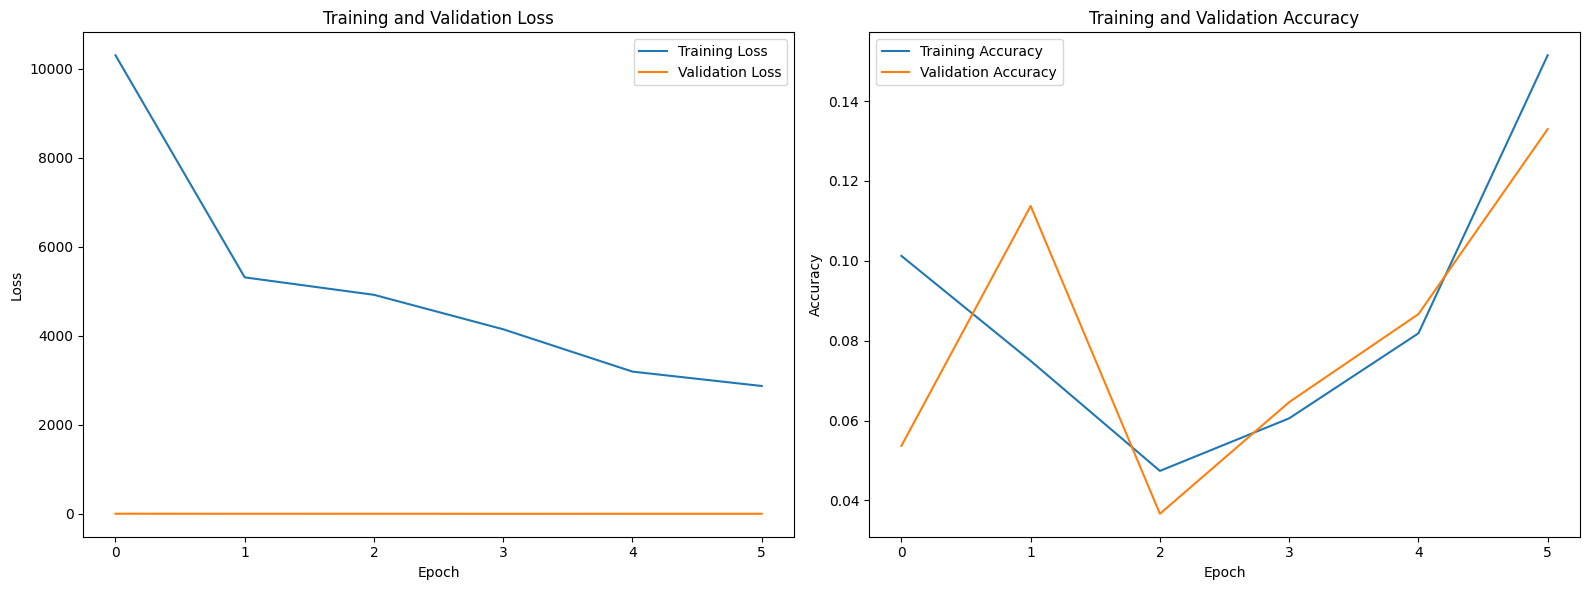


Evaluating model on test set...


2025-08-07 15:56:08.616905: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


499/499 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - bin_acc: 0.0641 - f1_macro: 0.0690 - loss: 3.0648 - pr_auc: 0.0554

Evaluation completed in 42.65 seconds

Test results:
loss: 3.0648
compile_metrics: 0.0641

Generating predictions...
499/499 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step

Metrics for each category:

TOXIC:
Precision: 0.0959
Recall: 1.0000
F1 Score: 0.1751
ROC AUC: 0.4020
PR AUC: 0.0854


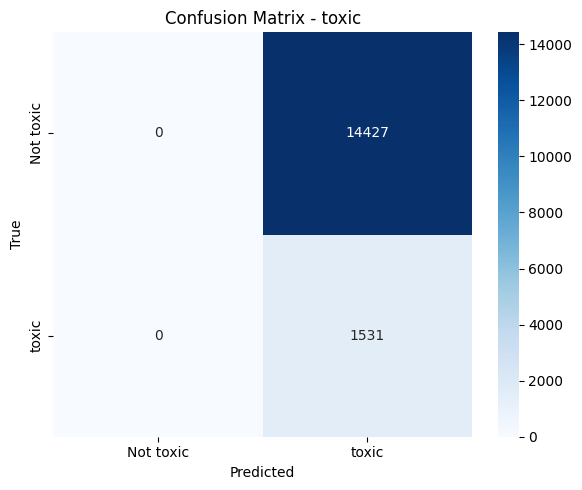


SEVERE_TOXIC:
Precision: 0.0103
Recall: 1.0000
F1 Score: 0.0203
ROC AUC: 0.7043
PR AUC: 0.1270


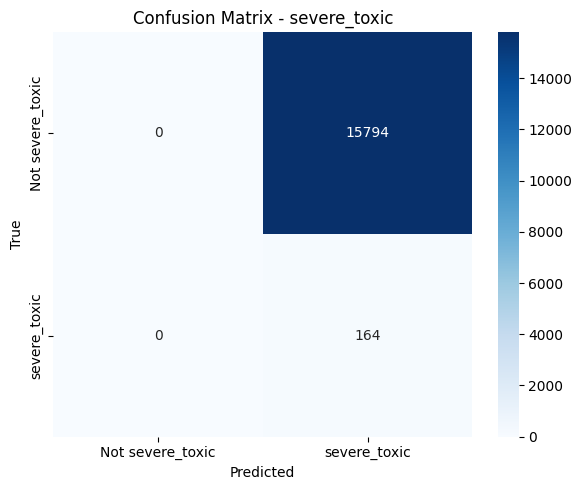


OBSCENE:
Precision: 0.0525
Recall: 1.0000
F1 Score: 0.0998
ROC AUC: 0.4416
PR AUC: 0.0671


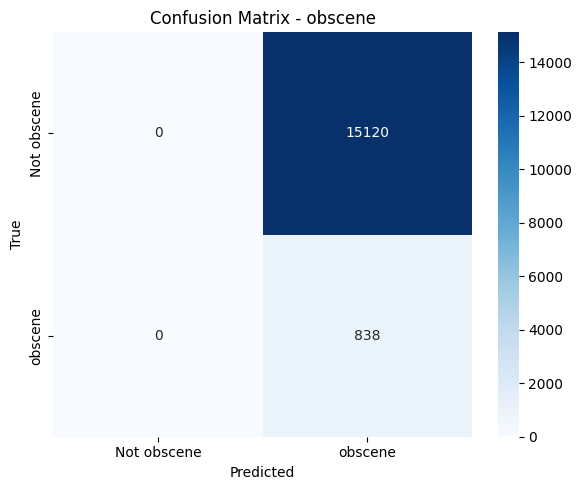


THREAT:
Precision: 0.0039
Recall: 0.9455
F1 Score: 0.0078
ROC AUC: 0.7537
PR AUC: 0.0500


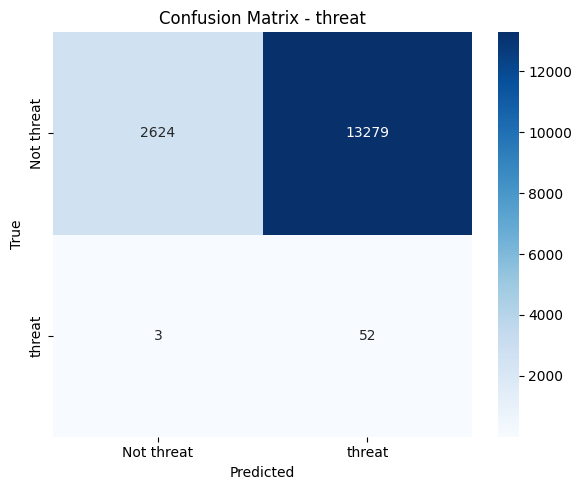


INSULT:
Precision: 0.0492
Recall: 1.0000
F1 Score: 0.0938
ROC AUC: 0.4443
PR AUC: 0.0623


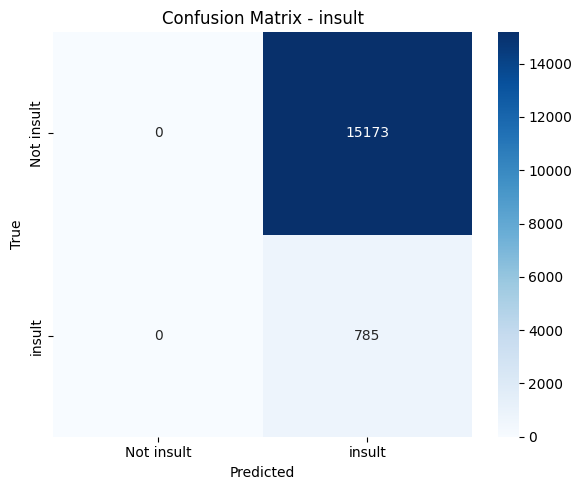


IDENTITY_HATE:
Precision: 0.0087
Recall: 1.0000
F1 Score: 0.0173
ROC AUC: 0.5644
PR AUC: 0.0200


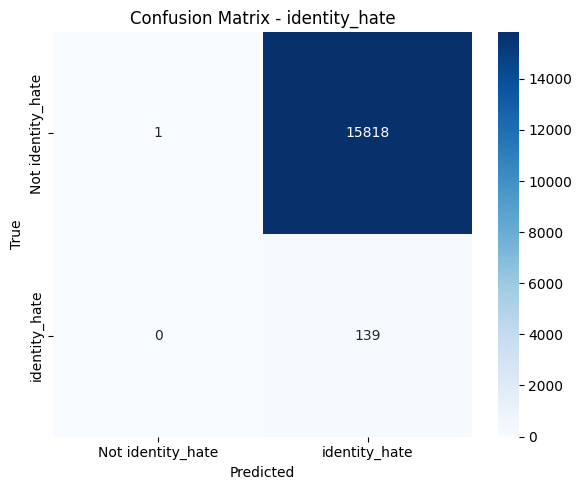

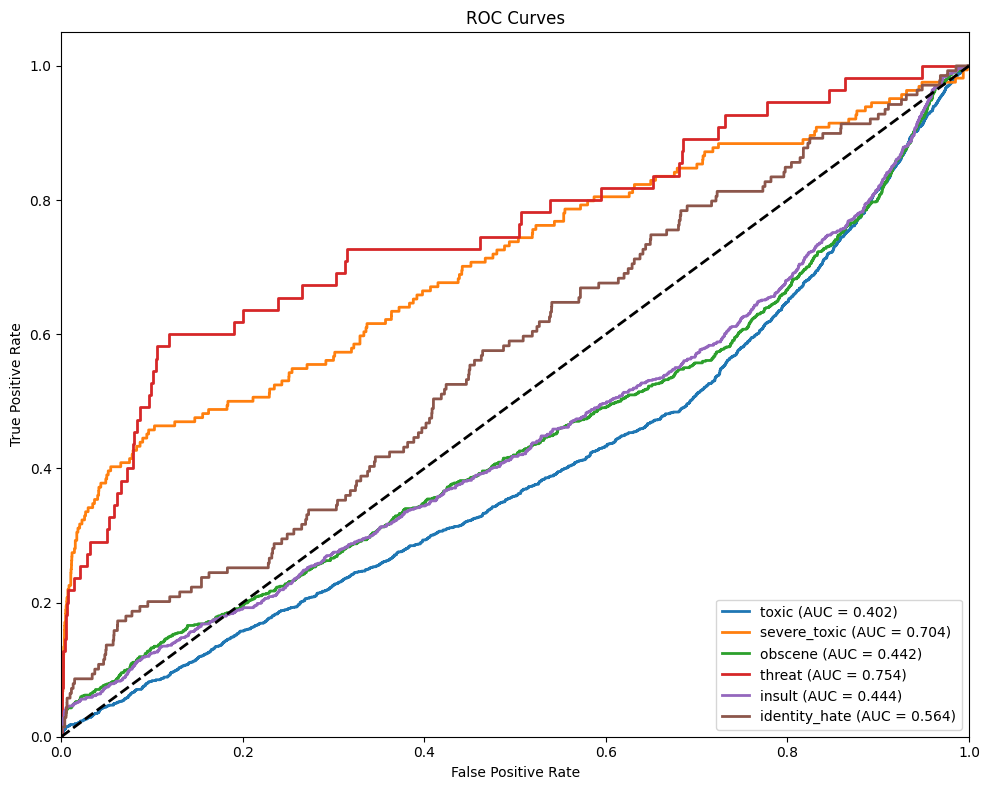

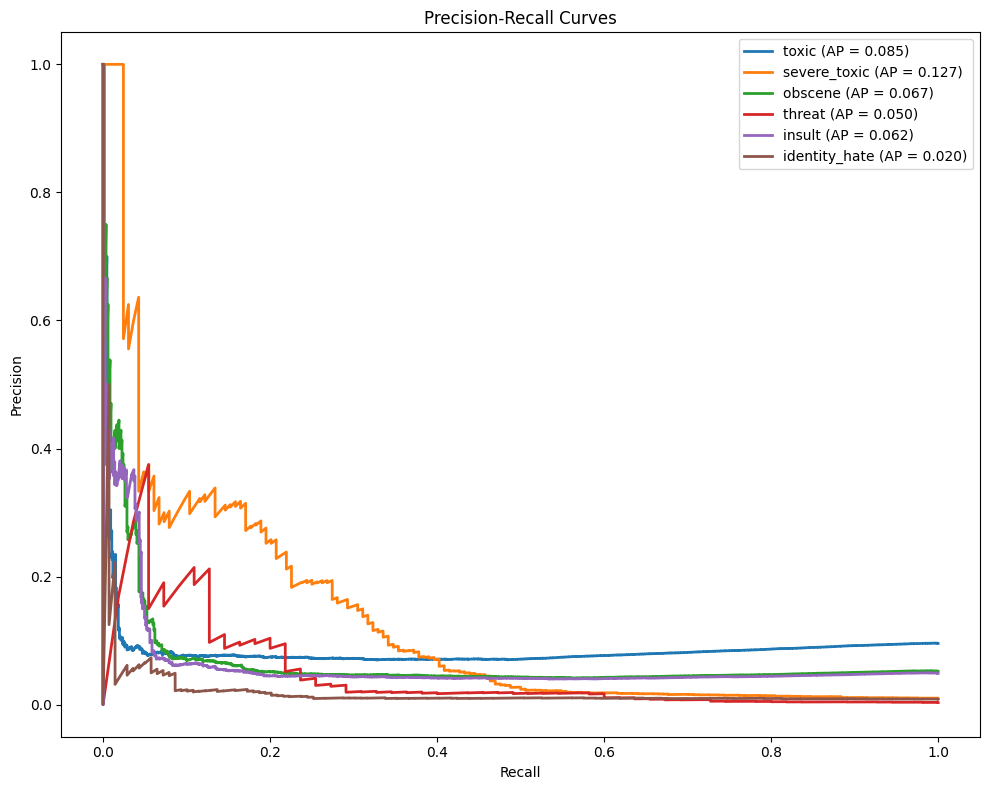


Overall Performance Report:
Macro-averaged Precision: 0.0368
Macro-averaged Recall: 0.9909
Macro-averaged F1: 0.0690
Micro-averaged Precision: 0.0377
Micro-averaged Recall: 0.9991
Micro-averaged F1: 0.0726

Testing with example comments:


ModuleNotFoundError: No module named 'filter'

In [1]:
# 7. Model Evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import sklearn.metrics as skmetrics
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import time

print("# 7. Model Evaluation")

# Load test data
print("Loading test data...")
X_test = np.load('X_test_tokenized.npy')
y_test = np.load('y_test.npy')

# Load the saved best model (the one with lowest validation loss)
print("Loading the best model...")
best_model = load_model('best_model.keras')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Define the category labels
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# 1. Plot training history
print("\nPlotting training history...")
plt.figure(figsize=(16, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['bin_acc'], label='Training Accuracy')
plt.plot(history['val_bin_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# 2. Evaluate model on test set
print("\nEvaluating model on test set...")
start_time = time.time()
test_results = best_model.evaluate(X_test, y_test, verbose=1)
evaluation_time = time.time() - start_time

print(f"\nEvaluation completed in {evaluation_time:.2f} seconds")
print("\nTest results:")
for metric_name, value in zip(best_model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

# 3. Generate predictions
print("\nGenerating predictions...")
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # Binary predictions with 0.5 threshold

# 4. Calculate metrics for each category
print("\nMetrics for each category:")
for i, label in enumerate(toxic_labels):
    precision = skmetrics.precision_score(y_test[:, i], y_pred[:, i])
    recall = skmetrics.recall_score(y_test[:, i], y_pred[:, i])
    f1 = skmetrics.f1_score(y_test[:, i], y_pred[:, i])
    auc_score = skmetrics.roc_auc_score(y_test[:, i], y_pred_proba[:, i])
    avg_precision = skmetrics.average_precision_score(y_test[:, i], y_pred_proba[:, i])
    
    print(f"\n{label.upper()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")
    print(f"PR AUC: {avg_precision:.4f}")
    
    # Confusion matrix for each category
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not ' + label, label], 
                yticklabels=['Not ' + label, label])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {label}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{label}.png')
    plt.show()

# 5. Plot ROC curves for all categories
plt.figure(figsize=(10, 8))
for i, label in enumerate(toxic_labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

# 6. Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i, label in enumerate(toxic_labels):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
    avg_prec = average_precision_score(y_test[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label} (AP = {avg_prec:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('precision_recall_curves.png')
plt.show()

# 7. Overall Performance Report
print("\nOverall Performance Report:")
macro_precision = skmetrics.precision_score(y_test, y_pred, average='macro')
macro_recall = skmetrics.recall_score(y_test, y_pred, average='macro')
macro_f1 = skmetrics.f1_score(y_test, y_pred, average='macro')
micro_precision = skmetrics.precision_score(y_test, y_pred, average='micro')
micro_recall = skmetrics.recall_score(y_test, y_pred, average='micro')
micro_f1 = skmetrics.f1_score(y_test, y_pred, average='micro')

print(f"Macro-averaged Precision: {macro_precision:.4f}")
print(f"Macro-averaged Recall: {macro_recall:.4f}")
print(f"Macro-averaged F1: {macro_f1:.4f}")
print(f"Micro-averaged Precision: {micro_precision:.4f}")
print(f"Micro-averaged Recall: {micro_recall:.4f}")
print(f"Micro-averaged F1: {micro_f1:.4f}")

# 8. Test with example comments
print("\nTesting with example comments:")

# Load the vocabulary and create a vectorizer
with open('vocabulary.txt', 'r') as f:
    saved_vocabulary = [line.strip() for line in f.readlines()]

# Create and configure the vectorizer
max_sequence_length = X_test.shape[1]  # Get from test data shape
word_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=len(saved_vocabulary),
    output_mode='int',
    output_sequence_length=max_sequence_length,
    standardize=None
)
word_vectorizer.set_vocabulary(saved_vocabulary)

# Import the normalize_text function if needed
from filter import normalize_text  # Assuming it's in a module called filter

# Example comments for testing
example_comments = [
    "This is a normal comment that should not be toxic.",
    "You are such an idiot, I hate you!",
    "I will kill you and your family",
    "This movie was terrible, I wasted my money",
    "<USER> your opinion is irrelevant because you're stupid",
    "I hate how people from that minority always cause problems"
]

# Normalize and predict
for comment in example_comments:
    # Normalize text
    normalized_comment = normalize_text(comment)
    
    # Vectorize
    vectorized_comment = word_vectorizer([normalized_comment])
    
    # Predict
    prediction = best_model.predict(vectorized_comment)[0]
    
    # Print results
    print(f"\nComment: {comment}")
    print(f"Normalized: {normalized_comment}")
    print("Predictions:")
    for i, label in enumerate(toxic_labels):
        prob = prediction[i]
        is_toxic = "YES" if prob > 0.5 else "NO"
        print(f"  {label}: {prob:.4f} ({is_toxic})")
    
    # Overall toxicity
    if any(prediction > 0.5):
        print("Overall: TOXIC COMMENT")
    else:
        print("Overall: SAFE COMMENT")

print("\nModel evaluation complete!")